In [20]:
# Load dependencies
%matplotlib inline
import matplotlib
import json
import time
import requests
import os.path
import pandas as pd
import numpy as np
from sklearn import decomposition
from scipy.stats import zscore
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Load data
df = pd.read_table('gata1_profile_spleen.txt',sep='\t',index_col=0)
genelist = df.index.values
samples = df.columns.values

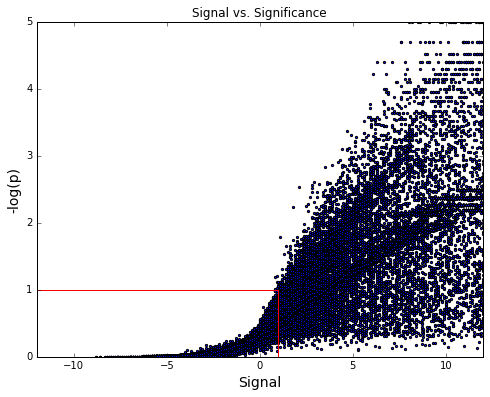

In [3]:
pvals = df[['cd1.Detection Pval','cd2.Detection Pval','cd3.Detection Pval',
            'gat1.Detection Pval','gat2.Detection Pval','gat3.Detection Pval']]
signal = df[['cd1.AVG_Signal','cd2.AVG_Signal','cd3.AVG_Signal',
             'gat1.AVG_Signal','gat2.AVG_Signal','gat3.AVG_Signal']]

fig = plt.figure(figsize=(8, 6), dpi=80)
x = list(pd.melt(signal)['value'])
y = list(pd.melt(-np.log10(pvals))['value'])
plt.axis([-12, 12, 0, 5])
plt.scatter(x,y,s=5)
plt.xlabel('Signal',fontsize=14)
plt.ylabel('-log(p)',fontsize=14)
plt.title('Signal vs. Significance')
plt.plot([-12,1],[1,1],'r-'); plt.plot([1,1],[0,1],'r-')
plt.show()

In [4]:
# Replace all negative values with zero
pd.options.mode.chained_assignment = None  # default='warn'
signal[signal < 0] = 0

# Remove that dont have nonzero values?
# keep = [ i for i in range(len(signal)) if sum(1 for j in range(6) if signal.iloc[i,j]>0)>=1 ]

df = signal
samples = [x.split('.')[0] for x in df.columns.values]
df.columns = samples

print "Old matrix:",signal.shape
print "New matrix:",df.shape

Old matrix: (30853, 6)
New matrix: (30853, 6)


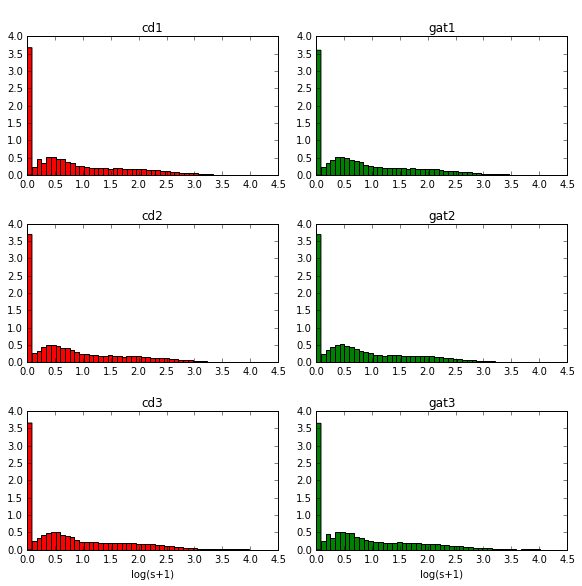

In [5]:
# Log transform
logDf = np.log10(df+1)

fig = plt.figure(figsize=(8, 8), dpi=80)

# Plot histograms of data
for i in range(1,7):
    fig.add_subplot(3,2,i)
    if i%2 == 0: s,col = 'gat' + str(i/2), 'green'
    else: s,col = 'cd' + str((i+1)/2), 'red'
    n, bins, patches = plt.hist(logDf[s], 50, normed=1, facecolor=col, alpha=1)
    plt.title('\n'+s)
    if int(s[-1]) == 3: plt.xlabel('log(s+1)')
plt.tight_layout(pad=0.4, w_pad=1.0, h_pad=0.8)

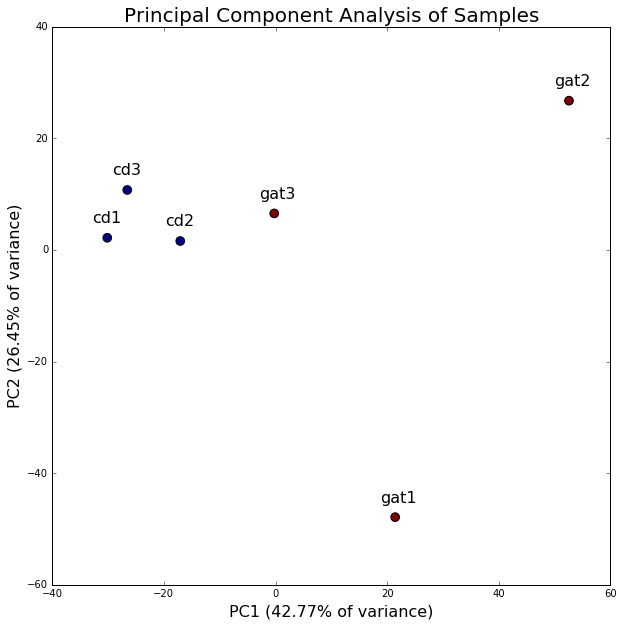

In [7]:
# Choose 2000 genes with greatest variance and zscore them
mat = df.transpose().as_matrix()
featvars = list(np.var(mat,axis=0))
select = np.argsort(featvars)[-2000:] 
mat = zscore(mat[:,select])

# Compute PCA Coordinates and Variance
pca = decomposition.PCA(n_components=None)
pca.fit(mat)
variance_explained = pca.explained_variance_ratio_[0:2] * 100
pca_coords = pca.transform(mat)[:, 0:2]
pca1, pca2 = zip(*pca_coords)

# Plot Results
fig = plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(pca1,pca2,s=75,c=[1,1,1,2,2,2])
labels = ['PC%s (%.2f' % (i,pct) + '%' + ' of variance)'
          for i,pct in enumerate(variance_explained, start=1)]
for label, x, y in zip(samples,pca1,pca2):
    plt.annotate(label,xy=(x,y),xytext = (-15, 15), textcoords = 'offset points', fontsize=16)
plt.xlabel(labels[0],fontsize=16)
plt.ylabel(labels[1],fontsize=16)
# plt.axis([-60, 50, -60, 60])
plt.title("Principal Component Analysis of Samples",fontsize=20)
plt.show()

In [8]:
from chdir import chdir

ctrData = df[['cd1','cd2','cd3']].values
expData = df[['gat1','gat2','gat3']].values

# Get the charactersitic direction signature
[cdGenes,cdVector] = chdir(ctrData,expData,genelist)

Calculating the characteristic direction.
Done chdir


In [10]:
# Libraries to use:
libraries = ['MGI_Mammalian_Phenotype_Level_4','WikiPathways_2015','ChEA_2015','PPI_Hub_Proteins']

# Use this function to call the Enrichr API:
ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/enrich'
def fetch_enrichr_results(genes, description=''):
    """Returns a dict which maps Enrichr libraries to enrichment results."""
    session = requests.session()
    payload = {'list': (None, genes), 'description': (None, description)}
    session.post(ENRICHR_URL, files=payload)
    results = {}
    for library in libraries:
        get_url = ENRICHR_URL + '?backgroundType=%s' % library
        response = session.get(get_url)
        print [str(x) for x in json.loads(response.text).keys()]
        if response.ok:
            results[library] = json.loads(response.text)[library]
        else: print "Error"
    return results

In [11]:
# Get 500 most up- and down-regulated genes
n = 500
geneOrder = [cdGenes[x] for x in np.argsort(cdVector)]
upGenes = geneOrder[-n:]
dnGenes = geneOrder[:n]

# Choose enrichr libraries to use
upOutput = fetch_enrichr_results('\n'.join(upGenes),'GATA1-/-')
dnOutput = fetch_enrichr_results('\n'.join(dnGenes),'GATA1-/-')

['MGI_Mammalian_Phenotype_Level_4']
['WikiPathways_2015']
['ChEA_2015']
['PPI_Hub_Proteins']
['MGI_Mammalian_Phenotype_Level_4']
['WikiPathways_2015']
['ChEA_2015']
['PPI_Hub_Proteins']


In [12]:
upResults = {}
dnResults = {}

nrows = 10 # Number of terms to display per library

# Do a little formatting
for library in libraries:
    upResults[library] = []
    dnResults[library] = []
    for i in range(len(upOutput[library])):
        line = [ '{:.4e}'.format(x) if type(x)==float else x for x in upOutput[library][i][:-2]]
        if library == 'KEGG_2016': line[1] = line[1][:-22]
        elif library == 'MGI_Mammalian_Phenotype_Level_4': line[1] = line[1][10:].replace('_',' ').title()
        elif library == 'WikiPathways_2015': line[1] = line[1].replace('(',' (').title()
        elif library == 'ChEA_2015': line[1] = '_'.join([line[1].split('_')[0]]+line[1].split('_')[2:])
        genestring = ', '.join(upOutput[library][i][-2])
        upResults[library].append(line + [genestring])
    for i in range(len(dnOutput[library])):
        line = [ '{:.4e}'.format(x) if type(x)==float else x for x in dnOutput[library][i][:-2]]
        if library == 'KEGG_2016': line[1] = line[1][:-22]
        elif library == 'MGI_Mammalian_Phenotype_Level_4': line[1] = line[1][10:].replace('_',' ').title()
        elif library == 'WikiPathways_2015': line[1] = line[1].replace('(',' (').title()
        elif library == 'ChEA_2015': line[1] = '_'.join([line[1].split('_')[0]]+line[1].split('_')[2:])
        genestring = ', '.join(dnOutput[library][i][-2])
        dnResults[library].append(line + [genestring])

In [31]:
fields = ["Rank","Term","p-value","z-score","Combined Score","Related Genes"]

# Now plot the tables
for library in libraries:
    up_df = pd.DataFrame(upResults[library], columns=fields).set_index('Rank')
    del up_df.index.name
    dn_df = pd.DataFrame(dnResults[library], columns=fields).set_index('Rank')
    del dn_df.index.name
    
    print library.replace('_',' ')+": Up"
    print display(up_df.head(10)) #.to_html()
    print library.replace('_',' ')+": Down"
    print display(dn_df.head(10)) #.to_html()


MGI Mammalian Phenotype Level 4: Up


,Term,p-value,z-score,Combined Score,Related Genes
1,Abnormal Innate Immunity,8.2357e-23,-1.6988e+00,7.6740e+01,"GRN, WDR1, LYZ2, NCF4, SLC40A1, FPR2, CFP, COR..."
2,Abnormal Immune Cell,2.8961e-21,-1.3723e+00,5.8058e+01,"WDR1, TNFRSF13B, NCF4, GIMAP1, SLC40A1, ARRB2,..."
3,Abnormal Adaptive Immunity,1.5788e-20,-1.3537e+00,5.5524e+01,"TNFRSF13B, WDR1, NCF4, GIMAP1, SLC40A1, ARRB2,..."
4,Abnormal Response To,3.2751e-14,-1.9352e+00,5.2569e+01,"GRN, LYZ2, NCF4, CFP, MPO, CORO1A, PIK3CG, HSP..."
5,Abnormal Antigen Presenting,1.0253e-16,-1.5769e+00,5.1289e+01,"GRN, WDR1, TNFRSF13B, CBFB, LYZ2, SLC40A1, FPR..."
6,Abnormal Immune System,4.7778e-15,-1.2596e+00,3.6411e+01,"VCP, GRN, WDR1, CBFB, TNFRSF13B, LYZ2, GIMAP1,..."
7,Abnormal Immune Tolerance,7.2787e-09,-2.2767e+00,3.4979e+01,"FCER1G, TNFRSF13B, DUSP1, LYZ2, FPR2, CFP, COR..."
8,Abnormal Inflammatory Respons,2.7053e-10,-1.8540e+00,3.4393e+01,"WDR1, TNFRSF13B, LYZ2, FPR2, ARRB2, MPO, CORO1..."
9,Abnormal Blood Cell,6.2512e-14,-1.2365e+00,3.2981e+01,"WDR1, TNFRSF13B, GIMAP1, SLC40A1, MPO, PIK3CG,..."
10,Abnormal Immune Serum,2.8910e-11,-1.4974e+00,3.0951e+01,"GRN, TNFRSF13B, CBFB, LYZ2, FPR2, ARRB2, CORO1..."


None
MGI Mammalian Phenotype Level 4: Down


,Term,p-value,z-score,Combined Score,Related Genes
1,Abnormal Adaptive Immunity,2.4894e-29,-1.3828e+00,8.2973e+01,"H2-T23, CD83, CD81, DGKA, CD3G, CD3E, ETS1, BA..."
2,Abnormal Immune Cell,2.0986e-28,-1.3723e+00,8.0370e+01,"H2-T23, CD83, CD81, DGKA, CD3G, CD3E, ETS1, BA..."
3,Abnormal Immune Serum,1.9822e-23,-1.5543e+00,7.4426e+01,"CD83, CD81, DGKA, TNFAIP3, LITAF, BACH2, RABGE..."
4,Abnormal Blood Cell,1.9774e-25,-1.2970e+00,6.7607e+01,"ALAS2, DYRK3, CD83, TFRC, CD81, DGKA, HBB-B1, ..."
5,Abnormal Bone Marrow,1.3686e-22,-1.3102e+00,6.0632e+01,"DYRK3, CD83, TFRC, CD81, DGKA, HBB-B1, SLC4A1,..."
6,Abnormal Immune System,2.2862e-23,-1.2596e+00,6.0313e+01,"CD83, CD81, DGKA, TNFAIP3, CD3G, CD3E, ETS1, C..."
7,Abnormal Antigen Presenting,7.1676e-18,-1.5338e+00,5.4551e+01,"CD83, CD81, ETS1, BACH2, RABGEF1, CD1D1, TBK1,..."
8,Abnormal Immune System,6.4632e-14,-1.5129e+00,4.0230e+01,"CEBPB, SATB1, CHD7, CXCR5, NEDD9, HBB-B1, SLC4..."
9,Abnormal Humoral Immune,1.6425e-11,-1.8989e+00,4.0203e+01,"CD83, CD81, SAMSN1, BACH2, RELA, RABGEF1, CD1D..."
10,Abnormal Spleen Morphology,4.5298e-11,-1.5342e+00,3.1086e+01,"CEBPB, TFRC, SATB1, CXCR5, HBB-B1, NEDD9, SLC4..."


None
WikiPathways 2015: Up


,Term,p-value,z-score,Combined Score,Related Genes
1,Electron Transport Chain (Homo Sapiens),8.7676e-11,-1.9826e+00,3.5438e+01,"NDUFA9, NDUFA7, NDUFB8, NDUFA3, NDUFA2, ATP5C1..."
2,Electron Transport Chain (Mus Musculus),7.0924e-10,-1.9141e+00,3.1537e+01,"NDUFA9, NDUFA7, NDUFB8, NDUFA3, NDUFA2, ATP5C1..."
3,Cytoplasmic Ribosomal Proteins (Homo Sapiens),1.3557e-09,-1.8810e+00,3.0536e+01,"RPL41, RPS9, RPL31, RPS8, RPLP1, RPS5, RPL13A,..."
4,Cytoplasmic Ribosomal Proteins (Mus Musculus),2.1942e-09,-1.8209e+00,2.9207e+01,"RPL31, RPS8, RPS5, RPL13A, RPL10A, RPS26, RPS1..."
5,Oxidative Phosphorylation (Mus Musculus),2.7488e-07,-1.8859e+00,2.1562e+01,"NDUFA9, ATP5B, NDUFA7, NDUFB8, NDUFA3, NDUFA2,..."
6,Oxidative Phosphorylation (Homo Sapiens),1.0920e-06,-1.8639e+00,1.9079e+01,"NDUFA9, ATP5B, NDUFA7, NDUFB8, NDUFA3, NDUFA2,..."
7,Proteasome Degradation (Mus Musculus),5.0544e-05,-1.7083e+00,1.1199e+01,"H2AFZ, HIST1H2AH, HIST1H2AK, PSMB1, HIST1H2AD,..."
8,Selenium Micronutrient Network (Homo Sapiens),7.7659e-03,-1.6795e+00,3.1531e+00,"PRDX5, GPX1, PRDX4, GPX4, IL1B, ALOX5AP, MPO"
9,Translation Factors (Mus Musculus),7.3552e-03,-1.6640e+00,3.1240e+00,"EEF1A1, EEF1B2, EEF1G, EIF3I, EIF4H"
10,Proteasome Degradation (Homo Sapiens),7.5251e-03,-1.6288e+00,3.0579e+00,"H2AFZ, PSMB1, PSMA7, PSMB10, PSMB8, PSMB9"


None
WikiPathways 2015: Down


,Term,p-value,z-score,Combined Score,Related Genes
1,Cytoplasmic Ribosomal Proteins (Mus Musculus),2.5934e-06,-1.9144e+00,1.4085e+01,"RPS15, RPL3, RPL18A, RPL32, RPS29, RPL12, RPL2..."
2,B Cell Receptor Signaling Pathway (Homo Sapiens),9.7206e-05,-2.0015e+00,1.0561e+01,"MAP4K1, NFKBIA, MEF2C, BCL6, CD81, IRF4, PLCG2..."
3,Cytoplasmic Ribosomal Proteins (Homo Sapiens),8.8234e-05,-1.9086e+00,1.0071e+01,"RPL3, RPL32, RPL12, RPS15, RPL18A, RPS29, RPL2..."
4,Adipogenesis Genes (Mus Musculus),1.0212e-04,-1.8814e+00,9.9273e+00,"CEBPB, EGR2, MBNL1, MEF2C, GADD45A, STAT3, IRS..."
5,Diurnally Regulated Genes With Circadian Ortho...,1.0884e-04,-1.8527e+00,9.7762e+00,"DAZAP2, HSPA8, PER1, PPP2CB, CEBPB, BTG1, KLF9..."
6,Diurnally Regulated Genes With Circadian Ortho...,1.4032e-04,-1.8344e+00,9.6798e+00,"DAZAP2, HSPA8, PER1, PPP2CB, CEBPB, BTG1, KLF9..."
7,Adipogenesis (Homo Sapiens),1.4538e-04,-1.8331e+00,9.6728e+00,"CEBPB, EGR2, MBNL1, MEF2C, GADD45A, STAT3, IRS..."
8,Exercise-Induced Circadian Regulation (Mus Mus...,1.7895e-04,-1.7643e+00,9.1789e+00,"DAZAP2, HSPA8, PER1, PPP2CB, CEBPB, BTG1, KLF9..."
9,Interferon Type I Signaling Pathways (Homo Sap...,4.7640e-04,-1.7097e+00,7.4222e+00,"EIF4A1, SOCS3, MAP3K1, LCK, STAT3, PDCD4, REL,..."
10,Tcr Signaling Pathway (Homo Sapiens),1.1939e-03,-1.7273e+00,6.0935e+00,"MAP4K1, NFKBIA, CD83, IRF4, REL, CD3G, CD3E, C..."


None
ChEA 2015: Up


,Term,p-value,z-score,Combined Score,Related Genes
1,EKLF_ChIP-Seq_ERYTHROCYTE_Mouse,2.9926e-43,-1.6185e+00,1.4997e+02,"HIBADH, WDR1, RPLP1, DBI, ETFB, ARRB2, RPL10A,..."
2,SPI1_ChIP-ChIP_GC-B_Mouse,6.0805e-30,-2.1789e+00,1.3786e+02,"ARL6IP1, NCF4, LST1, DBI, IFI30, B230342M21RIK..."
3,MYC_ChIP-ChIP_MESC_Mouse,8.3137e-48,-1.2280e+00,1.2582e+02,"IFITM3, IFITM2, ARL6IP1, RPL31, ATP5C1, RPL10A..."
4,MECOM_ChIP-Seq_KASUMI_Mouse,1.0618e-36,-1.4093e+00,1.1031e+02,"IFITM3, SLC46A3, WDR1, TNFRSF13B, ARL6IP1, NCF..."
5,E2F1_ChIP-Seq_MESC_Mouse,1.8073e-38,-1.1892e+00,9.7579e+01,"IFITM3, IFITM1, IFITM2, ARL6IP1, RPL31, ATP5C1..."
6,TAL1_ChIP-Seq_HPC-7_Mouse,8.7260e-32,-1.3981e+00,9.3922e+01,"RPL31, GIMAP1, LST1, ETFB, ATP5G3, ARRB2, RPL1..."
7,MYC_ChIP-ChIP_MESC_Mouse,3.4538e-30,-1.4115e+00,8.9887e+01,"IFITM2, HIBADH, ARL6IP1, RPL31, RPLP1, ATP5C1,..."
8,MYBL2_ChIP-ChIP_MESC_Mouse,2.7360e-22,-1.8805e+00,8.7008e+01,"IFITM3, IFITM1, IFITM2, ARL6IP1, RPL31, DBI, M..."
9,IRF8_ChIP-ChIP_GC-B_Mouse,7.8595e-16,-2.4096e+00,7.8039e+01,"TNFRSF13B, ARL6IP1, IGL-V1, NCF4, CENPA, GABAR..."
10,SPI1_ChIP-Seq_ERYTHROLEUKEMIA_Mouse,3.1731e-29,-1.2371e+00,7.6392e+01,"TNFAIP8, ARL6IP1, YWHAB, RPL31, LST1, ATP5C1, ..."


None
ChEA 2015: Down


,Term,p-value,z-score,Combined Score,Related Genes
1,STAT3_ChIP-Seq_CD4+T_Mouse,1.5979e-20,-5.2646e+00,2.2779e+02,"BTG1, CD83, TFRC, D16ERTD472E, TNFAIP3, SMG7, ..."
2,CLOCK_ChIP-Seq_293T_Human,5.3842e-30,-2.2898e+00,1.4638e+02,"DAZAP2, CEBPB, TFRC, CD82, BRI3, BHLHB2, NEDD9..."
3,FOXO1_ChIP-Seq_T-LYMPHOCYTE_Mouse,5.0202e-49,-1.3612e+00,1.4422e+02,"EIF4A1, CD83, DGKD, CD82, IRS2, ETS1, ETS2, BA..."
4,TAL1_ChIP-Seq_PRIMARY FETAL LIVER ERYTHROID _M...,5.4814e-39,-1.4787e+00,1.2412e+02,"PANK4, ALAS2, AHCTF1, CLIC4, BTG1, RPL3, TFRC,..."
5,MYC_ChIP-ChIP_MESC_Mouse,1.3322e-27,-2.0038e+00,1.1736e+02,"EIF4A1, RPL3, LDB1, RPL32, PPP1R10, ZFAND2A, D..."
6,MYB_ChIP-Seq_ERMYB_Mouse,1.1395e-29,-1.8386e+00,1.1630e+02,"CLIC4, BTG1, D16ERTD472E, CHD7, UBL3, NFKBIZ, ..."
7,CREB1_ChIP-Seq_GC1-SPG_Mouse,1.2193e-47,-1.1112e+00,1.1464e+02,"PANK4, EIF4A1, ISCA1, RPL3, RPL32, POP4, EIF4A..."
8,CREB1_ChIP-Seq_HIPPOCAMPUS_Rat,2.5441e-43,-1.2109e+00,1.1324e+02,"EIF4A1, ISCA1, POP4, EIF4A3, ACTB, FTH1, PIM3,..."
9,NUCKS1_ChIP-Seq_HEPATOCYTES_Mouse,2.3960e-26,-1.8941e+00,1.0610e+02,"EIF4A1, CEBPB, TFRC, CD82, DGKA, ODC1, SLC2A1,..."
10,STAT4_ChIP-ChIP_TH1 _Mouse,1.1979e-20,-2.3860e+00,1.0380e+02,"CD83, CD82, POP4, DGKA, D16ERTD472E, HBB-B2, N..."


None
PPI Hub Proteins: Up


,Term,p-value,z-score,Combined Score,Related Genes
1,SLC2A4,3.5968e-27,-1.2142e+00,6.7001e+01,"HIBADH, YWHAB, RPL31, ATP5C1, RPL10A, RPS4X, R..."
2,GABARAPL1,3.5253e-18,-1.2826e+00,4.5112e+01,"YWHAB, RPL31, RPLP1, GSTP1, ATP5C1, RPL10A, PI..."
3,HNRNPK,2.0143e-12,-1.6200e+00,3.6991e+01,"TPI1, ANXA2, RPS8, RPL31, RPS5, ARRB2, GABARAP..."
4,GABARAPL2,4.6202e-14,-1.2534e+00,3.2710e+01,"RPL31, RPLP1, GSTP1, PYGL, RPL10A, GABARAP, GS..."
5,EIF1B,9.0892e-11,-1.5519e+00,3.0253e+01,"RPS9, ANXA2, SSR4, RPL31, TALDO1, PSMA7, UBE2L..."
6,GABARAP,1.9961e-12,-1.2886e+00,2.9423e+01,"RPL31, RPLP1, GSTP1, RPL10A, GABARAP, HSP90B1,..."
7,ACTB,3.6489e-11,-1.3492e+00,2.7351e+01,"RPS9, ANXA2, RPS8, YWHAB, RPLP1, ARRB2, ARPC5,..."
8,231403,2.3454e-09,-1.4931e+00,2.4585e+01,"MCTS1, RPS9, VCP, ANXA2, PYGL, PGD, GSPT1, PSM..."
9,EIF2C2,4.5852e-09,-1.5189e+00,2.4177e+01,"RPS9, SSR4, RPL31, RPS5, ATP5C1, RPL13A, RPL10..."
10,MAP1LC3A,3.8214e-10,-1.3204e+00,2.3998e+01,"RPS9, SSR4, RPS8, RPL31, RPLP1, GSTP1, HNRNPAB..."


None
PPI Hub Proteins: Down


,Term,p-value,z-score,Combined Score,Related Genes
1,UBC,4.0447e-14,-1.2441e+00,3.1198e+01,"DAZAP2, CD81, AKAP8L, CXCR4, NEDD9, TNFAIP3, I..."
2,MAP3K1,5.1330e-10,-1.4609e+00,2.4617e+01,"HSPA9, MAP4K1, HSPA8, MAP3K1, RPL3, CD82, ACTN..."
3,SP1,7.8634e-09,-1.6070e+00,2.4070e+01,"HSPA8, EGR1, MEF2C, CEBPB, LDB1, STAT3, LMO2, ..."
4,GABARAPL2,9.7754e-11,-1.2694e+00,2.2823e+01,"EIF4A1, RPL3, WBP2, CUL3, RPL12, STK4, ACTB, S..."
5,RELA,1.9453e-09,-1.4128e+00,2.2471e+01,"HSPA9, HSPA8, EGR1, CEBPB, TSC22D3, STAT3, AKA..."
6,GABARAP,6.0493e-10,-1.2886e+00,2.1714e+01,"EIF4A1, RPL3, TFRC, WBP2, CUL3, RPL12, STK4, A..."
7,NFKB1,1.5992e-07,-1.6941e+00,2.1219e+01,"HSPA9, HSPA8, CEBPB, IFNGR1, TSC22D3, STAT3, E..."
8,NFKB2,1.3842e-07,-1.5200e+00,1.9040e+01,"HSPA9, HSPA8, TSC22D3, STAT3, RELA, NFKBIA, TB..."
9,ESR1,3.3189e-09,-1.2114e+00,1.8842e+01,"EIF4A1, CEBPB, RPL3, LDB1, TFRC, RPL12, IRS2, ..."
10,LCK,5.1512e-08,-1.2862e+00,1.7257e+01,"SH2D2A, DGKA, STAT3, NEDD9, SLC4A1, THY1, CD3E..."


None
